In [1]:
%load_ext autoreload
%autoreload 2

# Preparations


In [2]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

file exists: /home/lisajsch/repos/Plenum/local/e_psf_grid_psimax-3_bins-25.pckl
file exists: /home/lisajsch/repos/Plenum/local/GP_Eres_mephistograms.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Elementary arithmetic possible.
True


# Imports

In [3]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from settings import *
from tools import array_source_interp, poisson_llh
from tqdm import tqdm

from collections import namedtuple
import fluxes as fx



In [4]:
# flux templates
flux_collection = {
    "powerlaw": fx.PL_flux,
    "powerlaw with cutoff": fx.PLcut_flux,
    "log-parabola": fx.LogP_flux,
}
# baseline flux definitions
base_flux_collection = {
    "powerlaw": fx.baseline_pl_flux,
    "powerlaw with cutoff": fx.baseline_cut_flux,
    "log-parabola": fx.baseline_para_flux,
}

# bounds flux parameters
bounds_flux_collection = {
    "powerlaw": fx.bounds_pl_flux,
    "powerlaw with cutoff": fx.bounds_cut_flux,
    "log-parabola": fx.bounds_para_flux,
}

# we base the flux models on named-tuples
diffuse_flux = flux_collection["powerlaw"](PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")
diffuse_flux==base_flux_collection["powerlaw"] # it's the same! diffuse flux with baseline parameters

True

In [5]:
print(LIVETIME)
print(GAMMA_ASTRO)
print(PHI_ASTRO)

275270400
2.37
1.44e-18


In [6]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_MH_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_MH_up.pckl"),
    "improved-20": join(LOCALPATH, "improved_0.2_artificial_energy_smearing_MH_up.pckl"),
    "improved-50": join(LOCALPATH, "improved_0.5_artificial_energy_smearing_MH_up.pckl"),
}

# plot settings for different configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + P-ONE",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}


# Effective areas
We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [7]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

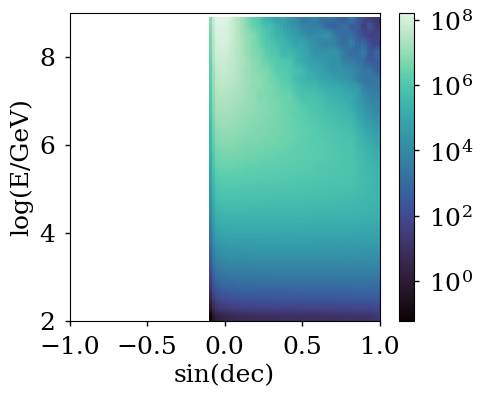

In [8]:
aeff_2d["IceCube"].plot(norm=LogNorm())

### background

In [9]:
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo.match(aeff_2d["IceCube"], verbose=True))


Elementary arithmetic possible.
True


# energy smearing with KDE

In [10]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1) # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1) # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))


Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (100, 140);
False


# Event numbers

In [11]:
from aeff_calculations import aeff_eval_e_sd
from resolution import energy_smearing
from settings import E_NORM

In [12]:
# check
for det in ["IceCube", "Plenum-1"]:
    aeff_factor = aeff_eval_e_sd(aeff_2d[det], sindec_width, ewidth, ra_width) * LIVETIME
    astro_ev = aeff_factor * (emids/E_NORM)**(-GAMMA_ASTRO) * PHI_ASTRO
    atm_ev = aeff_factor * bckg_histo

    print(det)
    print("conv events:", np.sum(atm_ev))
    print("astro events:", np.sum(astro_ev))

# energy smearing
print("astro events with energy smearing:", np.sum(energy_smearing(baseline_eres, astro_ev)))

IceCube
conv events: 634420.7621554744
astro events: 2682.276523458852
Plenum-1
conv events: 2587988.4196645003
astro events: 10803.498070757794
astro events with energy smearing: 10803.498070757794


# same calculation, but with Config

In [13]:
# generic diffuse flux config
diffuse_config = dict(
    sindec_mids=sindec_mids,
    sindec_width=sindec_width,
    livetime=LIVETIME,
    ewidth=ewidth,
    diff_or_ps="diff",
)


parameters for analysis:
* Global normalization of the atmospheric neutrino flux (background), $N_B$
* Global normalization of the astrophysical neutrino flux (signal), $N_S$
* Spectral index, GAMMA_ASTRO, of the astrophysical neutrino flux (signal), $\gamma$

In [14]:
def asimov_data(
    aeff_factor,
    flux,
    emids=emids,
    e_res=baseline_eres,
    phi_scaling=1,
    bckg_histo=bckg_histo,
):
    # asimov = expectation of perfect experiment
    k_b = atmo_background(aeff_factor, bckg_histo, e_res)
    k_s = astro_flux(
        aeff_factor,
        emids,
        energy_resolution=e_res,
        phi_scaling=phi_scaling,
        flux_shape=flux,
    )
    return k_s, k_b


In [15]:
aeff_factor = calc_aeff_factor(aeff_2d["IceCube"], **diffuse_config)

# asimov data
# in reconstructed energy
k_s, k_b = asimov_data(aeff_factor, diffuse_flux)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))
print("Signal:", np.sum(k_s))
print("S+B", np.sum(k_i))


Asimov data sum:
Background: 634420.7621554744
Signal: 2682.276523458852
S+B 637103.0386789333


Text(0.5, 1.0, 'Astro events')

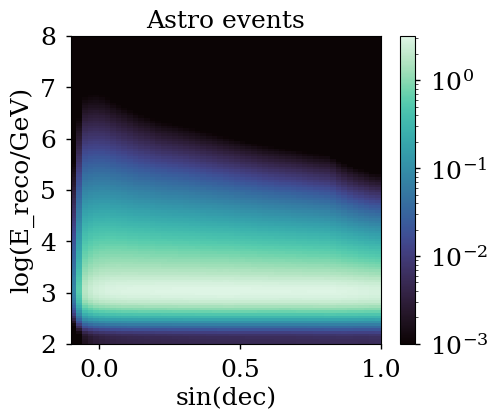

In [16]:
k_s.plot(norm=LogNorm(vmin=1E-3))

ax = plt.gca()
ax.set_xlim(-0.1, 1)
ax.set_ylim(2, 8)
ax.set_title("Astro events")


## Simple diffuse flux fit

## plot exemplary shapes

NameError: name 'energy_resolution' is not defined

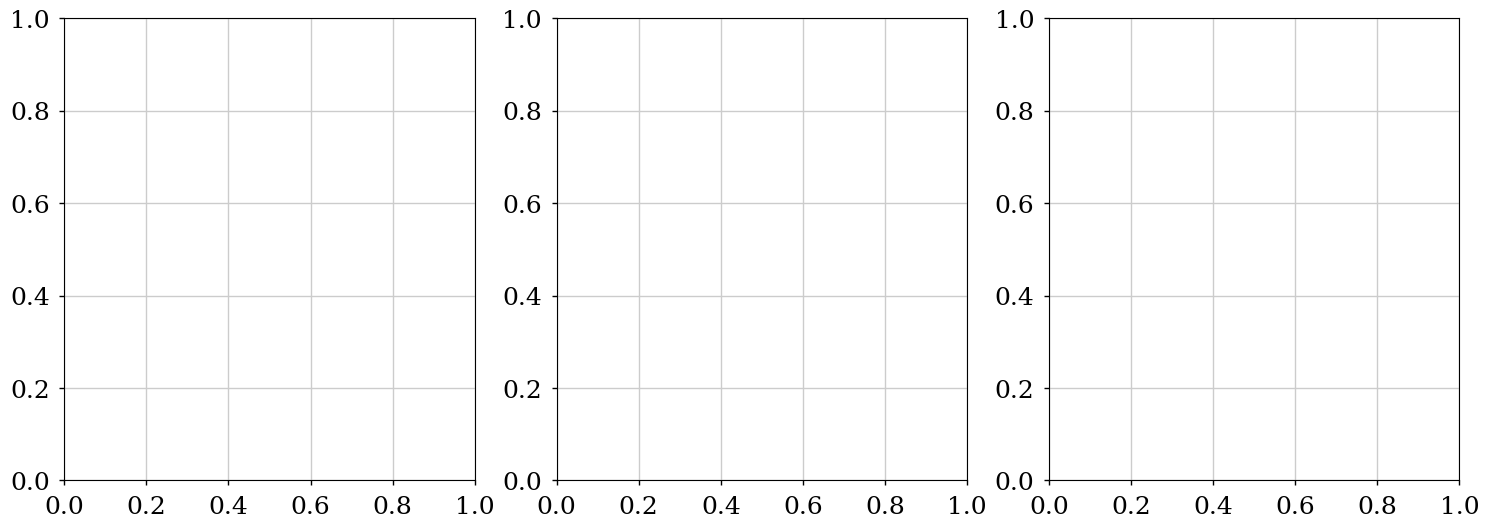

In [17]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for shape in base_flux_collection:
    f, axes = plt.subplots(ncols=3, figsize=(18, 6))
    for i, ident in enumerate(idents):
        ax = axes[i]
        aeff_factor = (
            aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
        )
        events = [
            np.sum(
                astro_flux(
                    aeff_factor,
                    emids,
                    normed_kvals=energy_resolution,
                    phi_scaling=1,
                    flux_shape=base_flux_collection[shape],
                ),
                axis=0,
            ),
            np.sum(
                astro_flux(
                    aeff_factor,
                    emids,
                    normed_kvals=energy_resolution,
                    phi_scaling=1,
                    flux_shape=fx.baseline_pl_flux,
                ),
                axis=0,
            ),
            np.sum(atmo_background(aeff_factor, spl_vals, energy_resolution), axis=0),
        ]
        plot_labels = [shape, "Powerlaw", "Conv."]
        ls = ["-", "--", "-"]
        color = [None, "k", "gray"]
        f, ax = plot_spectrum(
            logE_reco_mids,
            events,
            plot_labels,
            title=ident,
            f=f,
            ax=ax,
            ls=ls,
            color=color,
        )


# Define likelihood and test statistic

In [ ]:
def diffuse_llh_2d_composite(
    x,
    mu_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    spl_vals=spl_vals,
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2]: signal spectral index

    see 'astro_flux' for further shapes and parameters

    mu_base: effective area factor
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape, default 'powerlaw'
    """
    mu_i = asimov_data(
        aeff_factor=aeff_factor,
        flux=flux_collection[shape](phi_0, *x[2:], e_0, shape),
        phi_scaling=x[1],
        bg_vals=spl_vals * x[0],
        e_res=normed_kvals
    )

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# astro vs atmo fit

In [ ]:
ident = "IceCube"
shape = "powerlaw"
print(shape)

aeff_factor = aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
# asimov = expectation of perfect experiment
k_i = asimov_data(aeff_factor=aeff_factor, flux=fx.baseline_pl_flux)

fit_config = dict(
    mu_base=aeff_factor,
    k_i=k_i,
    e_0=E_NORM,
    phi_0=PHI_ASTRO,
    normed_kvals=energy_resolution,
    shape=shape,
)
# baseline atmo
local_llh = lambda x: diffuse_llh_2d_composite((x[0], 0, 2), **fit_config)
# atmo+astro
global_llh = lambda x: diffuse_llh_2d_composite(x,**fit_config)
out_pl = fmin_l_bfgs_b(
    local_llh,
    x0=(1.1, ),
    approx_grad=True,
)

# global min
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1, 2.3),
    approx_grad=True,
    factr=10,
)
print("shape fit:", out_comp[0])
if out_comp[2]["warnflag"] != 0:
    print("WARNING!! signal fit did not converge properly")
    print(out_comp)

# check that the TS at the fit minimum is close to the TS of the baseline params
baseline_ts = global_llh((1, 1, *base_flux_collection[shape][1:-2]))
baseline_ts_check = np.isclose(out_comp[1], baseline_ts, rtol=1e-3)
print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
if not baseline_ts_check:
    print("fit: ", out_comp[1], ", reference:", baseline_ts)

## be aware: this doesn't tell you whether or not the fit worked
## a 2D scan can confirm (see below)
print("pl fit:", out_pl[0])
pval = chi2.sf(out_pl[1] - out_comp[1], 1)
significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)


powerlaw
shape fit: [1.00000023 0.99996989 2.36999663]
TS asimov check: OK
pl fit: [1.00424182]
P-VALUE: 2.359077501253936e-13 , SIGNIFICANCE: 7.326744164356422


## Loop through different shapes and make a spectral fit

In [ ]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
verbose = False
fit_results = {}
for shape in base_flux_collection:
    print(shape)
    fit_results[shape] = {}
    for li, ident in enumerate(idents):
        print(ident)
        aeff_factor = (
            aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
        )
        if "Plenum" in ident:
            aeff_factor += (
                aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
                * LIVETIME
            )
        # asimov = expectation of perfect experiment
        k_i = asimov_data(aeff_factor=aeff_factor, flux=base_flux_collection[shape])

        fit_config = dict(
            mu_base=aeff_factor,
            k_i=k_i,
            e_0=E_NORM,
            phi_0=PHI_ASTRO,
            normed_kvals=energy_resolution,
        )
        # baseline astro
        local_llh = lambda x: diffuse_llh_2d_composite(x, shape="powerlaw", **fit_config)
        # astro shape
        global_llh = lambda x: diffuse_llh_2d_composite(x, shape=shape, **fit_config)
        out_pl = fmin_l_bfgs_b(
            local_llh,
            x0=(1, 1, GAMMA_ASTRO),
            bounds=[(1e-3, 1e2), *fx.bounds_pl_flux[:-2]],
            approx_grad=True,
        )

        # global min
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.1, *base_flux_collection[shape][:-2]),
            bounds=[(1e-3, 1e2), *bounds_flux_collection[shape][:-2]],
            approx_grad=True,
            factr=10,
        )
        print("shape fit:", out_comp[0])
        fit_results[shape][ident] = out_comp
        if out_comp[2]["warnflag"] != 0:
            print("WARNING!! signal fit did not converge properly")
            print(out_comp)

        # check that the TS at the fit minimum is close to the TS of the baseline params
        baseline_ts = global_llh((1, 1, *base_flux_collection[shape][1:-2]))
        baseline_ts_check = np.isclose(out_comp[1], baseline_ts, rtol=1e-3)
        print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
        if not baseline_ts_check:
            print("fit: ", out_comp[1], ", reference:", baseline_ts)
        
        ## be aware: this doesn't tell you whether or not the fit worked
        ## a 2D scan can confirm (see below)
        print("pl fit:", out_pl[0])
        pval = chi2.sf(out_pl[1] - out_comp[1], 1)
        significance = erfinv(1 - pval) * np.sqrt(2)
        print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)
        print("--" * 30)
    print("- -" * 30)


powerlaw
IceCube
shape fit: [0.99999951 1.00002763 2.37001957]
TS asimov check: OK
pl fit: [1.   1.   2.37]
P-VALUE: 1.0 , SIGNIFICANCE: 0.0
------------------------------------------------------------
Plenum-1
shape fit: [0.99999998 1.00000124 2.36999917]
TS asimov check: OK
pl fit: [1.   1.   2.37]
P-VALUE: 1.0 , SIGNIFICANCE: 0.0
------------------------------------------------------------
Plenum-2
shape fit: [1.00000009 0.99999206 2.36999403]
WARNING!! signal fit did not converge properly
(array([1.00000009, 0.99999206, 2.36999403]), 5806.332687707472, {'grad': array([0.02619345, 0.02692104, 0.01600711]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 436, 'nit': 28, 'warnflag': 2})
TS asimov check: OK
pl fit: [1.   1.   2.37]
P-VALUE: 1.0 , SIGNIFICANCE: 0.0
------------------------------------------------------------
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
powerlaw with cutoff
IceCube
shape fit: [0.99997734 1.03508904 2.00

# 1D scan powerlaw
Calculate expected parameter uncertainties

In [ ]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 100
gamma_astro_scaling = np.linspace(2.1, 2.6, num=num + 1)
astro_scaling = np.linspace(0.5, 1.5, num=num)
verbose = False
shape = "powerlaw"


In [ ]:
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}}
local_SPL_gamma_scan = {"ts": {}, "conv": {}, "phi_astro": {}}
local_SPL_phi_scan = {"ts": {}, "conv": {}, "gamma": {}}
for ident in idents:
    print(ident)
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    if "Plenum" in ident:
        aeff_factor += (
            aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
            * LIVETIME
        )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor=aeff_factor, flux=base_flux_collection[shape])
    fit_config = dict(
        mu_base=aeff_factor,
        k_i=k_i,
        e_0=E_NORM,
        phi_0=PHI_ASTRO,
        normed_kvals=energy_resolution,
        shape="powerlaw",
    )
    # astro shape
    global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, *base_flux_collection[shape][1:-2]),
        bounds=[(1e-3, 1e2), *bounds_flux_collection[shape][:-2]],
        approx_grad=True,
    )

    if out_comp[2]["warnflag"] != 0:
        print("WARNING!!")
        print("bf param:", out_comp[0])

    bf_SPL["ts"][ident] = out_comp[1]
    bf_SPL["conv"][ident] = out_comp[0][0]
    bf_SPL["phi_astro"][ident] = out_comp[0][1]
    bf_SPL["gamma"][ident] = out_comp[0][2]

    local_SPL_gamma_scan["ts"][ident] = np.zeros_like(gamma_astro_scaling) * np.nan
    local_SPL_gamma_scan["conv"][ident] = np.zeros_like(gamma_astro_scaling) * np.nan
    local_SPL_gamma_scan["phi_astro"][ident] = (
        np.zeros_like(gamma_astro_scaling) * np.nan
    )
    print("starting local fits...")
    for j, gas in enumerate(gamma_astro_scaling):
        # local min with fixed gamma_astro_scaling
        local_llh = lambda x: diffuse_llh_2d_composite((x[0], x[1], gas), **fit_config)
        local_out = fmin_l_bfgs_b(local_llh, x0=[1.0, 1.0], approx_grad=True, maxls=35)
        if local_out[2]["warnflag"] == 0:
            local_SPL_gamma_scan["conv"][ident][j] = local_out[0][0]
            local_SPL_gamma_scan["phi_astro"][ident][j] = local_out[0][1]
            local_SPL_gamma_scan["ts"][ident][j] = local_out[1]

    local_SPL_phi_scan["ts"][ident] = np.zeros_like(astro_scaling) * np.nan
    local_SPL_phi_scan["conv"][ident] = np.zeros_like(astro_scaling) * np.nan
    local_SPL_phi_scan["gamma"][ident] = np.zeros_like(astro_scaling) * np.nan
    print("starting local fits...")
    for j, aas in enumerate(astro_scaling):
        # local min with fixed phi_astro
        local_llh = lambda x: diffuse_llh_2d_composite((x[0], aas, x[1]), **fit_config)
        local_out = fmin_l_bfgs_b(
            local_llh,
            x0=[1.0, 2.2],
            approx_grad=True,
            maxls=35,
        )
        if local_out[2]["warnflag"] == 0:
            local_SPL_phi_scan["conv"][ident][j] = local_out[0][0]
            local_SPL_phi_scan["gamma"][ident][j] = local_out[0][1]
            local_SPL_phi_scan["ts"][ident][j] = local_out[1]
    print("done")


IceCube
WARNING!!
bf param: [1.   1.   2.37]
starting local fits...
starting local fits...
done
Plenum-1
starting local fits...
starting local fits...
done
Plenum-2
WARNING!!
bf param: [1.   1.   2.37]
starting local fits...
starting local fits...
done


Text(0, 0.5, '-2$\\Delta$LLH')

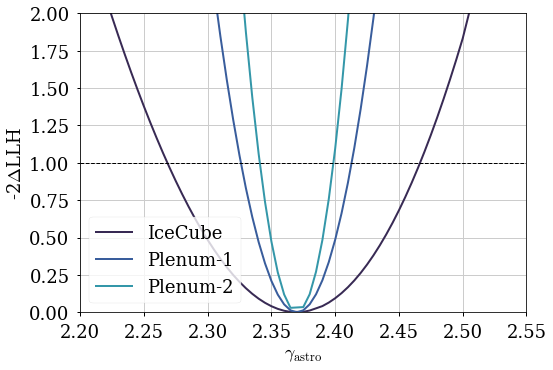

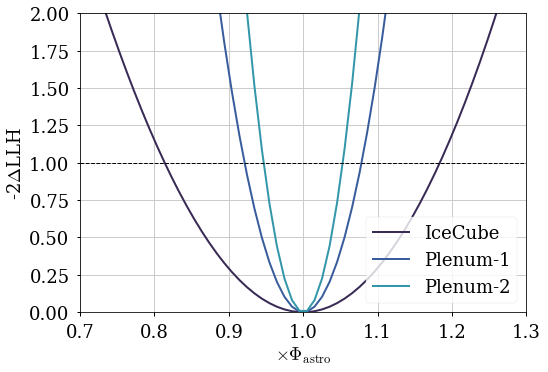

In [ ]:
plt.figure()
for ident in idents:
    # mask invalid values where the fit failed
    mask = local_SPL_gamma_scan["ts"][ident] >= bf_SPL["ts"][ident]
    plt.plot(
        gamma_astro_scaling[mask],
        local_SPL_gamma_scan["ts"][ident][mask] - bf_SPL["ts"][ident],
        label=ident,
    )
plt.axhline(1, ls="--", color="k", lw=1)
plt.ylim(0, 2)
plt.xlim(2.2, 2.55)
plt.legend(loc=3)
plt.xlabel(r"$\gamma_{\rm astro}$")
plt.ylabel(r"-2$\Delta$LLH")

plt.figure()
for ident in idents:
    # mask invalid values where the fit failed
    mask = local_SPL_phi_scan["ts"][ident] >= bf_SPL["ts"][ident]
    plt.plot(
        astro_scaling[mask],
        local_SPL_phi_scan["ts"][ident][mask] - bf_SPL["ts"][ident],
        label=ident,
    )
plt.axhline(1, ls="--", color="k", lw=1)
plt.ylim(0, 2)
plt.xlim(0.7, 1.3)
plt.legend(loc=4)
plt.xlabel(r"$\times \Phi_{\rm astro}$")
plt.ylabel(r"-2$\Delta$LLH")


# 2D scan powerlaw
Show that we can roughly reproduce the diffuse results from ICRC2019

In [ ]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 60
gamma_astro_scaling = np.linspace(1.9, 2.9, num=num+1)
astro_scaling = np.linspace(0.4, 1.7, num=num)
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}}
local_SPL = {"ts": {}, "conv": {}}
shape = "powerlaw"
for ident in idents:
    print(ident)
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    if "Plenum" in ident:
        aeff_factor += (
            aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
            * LIVETIME
        )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor=aeff_factor, flux=base_flux_collection[shape])
    fit_config = dict(
        mu_base=aeff_factor,
        k_i=k_i,
        e_0=E_NORM,
        phi_0=PHI_ASTRO,
        normed_kvals=energy_resolution,
        shape="powerlaw",
    )
    # astro shape
    global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
    out = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, *base_flux_collection[shape][1:-2]),
        bounds=[(1e-3, 1e2), *bounds_flux_collection[shape][:-2]],
        approx_grad=True,
    )

    if out[2]["warnflag"] != 0:
        print("WARNING!!")
        print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["phi_astro"][ident] = out[0][1]
    bf_SPL["gamma"][ident] = out[0][2]

    local_SPL["ts"][ident] = np.zeros((num, num + 1))
    local_SPL["conv"][ident] = np.zeros((num, num + 1))
    print("starting local fits...")
    for i, asc in enumerate(astro_scaling):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed phi_astro
            local_llh = lambda x: diffuse_llh_2d_composite((x[0], asc, gas), **fit_config)
            local_out = fmin_l_bfgs_b(local_llh, x0=[1.1], approx_grad=True, maxls=35)
            (local_SPL["conv"][ident][i][j],) = local_out[0]
            local_SPL["ts"][ident][i][j] = local_out[1]
    print("done")


## contour comparison

In [ ]:
# comparison data of official 9.5yr fit by Jöran Stettner (IceCube ICRC2019)
diffuse_10yr_ref = np.genfromtxt("../resources/diffuse_contour_95_2021.txt")

In [ ]:
from settings import poles, PHI_ASTRO_FACTOR

In [ ]:
### only 95% contours
contour_formats = {
    "IceCube": {"colors": [poles["IceCube"]["color"]], "linestyles": "--"},
    "Plenum-1": {
        "colors": [poles["Plenum-1"]["color"]],
        "linestyles": poles["Plenum-1"]["ls"],
    },
    "Plenum-2": {
        "colors": [poles["Plenum-2"]["color"]],
        "linestyles": poles["Plenum-2"]["ls"],
    },
}


In [ ]:
from settings import PHI_ASTRO_FACTOR

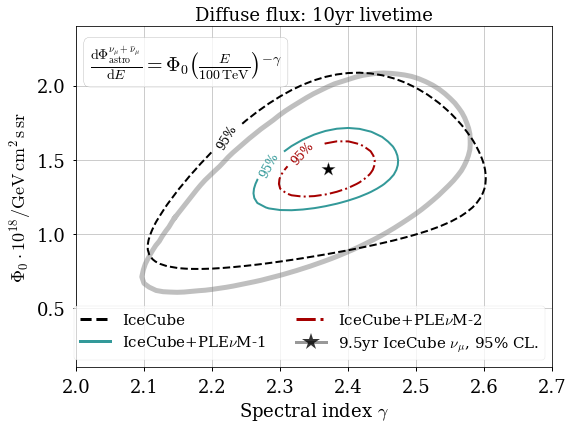

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
## correctly sort extracted contour from joeran's latest diffuse fit
ref_color = "gray"
ax.plot(
    diffuse_10yr_ref[0],
    diffuse_10yr_ref[1],
    color=ref_color,
    ls="-",
    lw=5,
    alpha=0.5,
)

# draw contour levels
cvals = [0.05]
lbs = ["95%"]
levels = chi2.isf(cvals, 2)
for ident in idents:
    sc = ax.contour(
        gamma_astro_scaling,
        astro_scaling * PHI_ASTRO_FACTOR,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        lw=3,
        **contour_formats[ident],
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=12)
# best fit
ax.scatter(
    bf_SPL["gamma"][ident],
    bf_SPL["phi_astro"][ident]* PHI_ASTRO_FACTOR,
    marker="*",
    s=200,
    color="k",
    edgecolor=ref_color,
)
lines = [
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["IceCube"]["colors"][0],
        ls=contour_formats["IceCube"]["linestyles"],
        lw=3,
        label="IceCube",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-1"]["colors"][0],
        ls=contour_formats["Plenum-1"]["linestyles"],
        lw=3,
        label=r"IceCube+PLE$\nu$M-1",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-2"]["colors"][0],
        ls=contour_formats["Plenum-2"]["linestyles"],
        lw=3,
        label=r"IceCube+PLE$\nu$M-2",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=ref_color,
        ls="-",
        lw=3,
        markersize=18,
        alpha=0.8,
        marker="*",
        mfc="k",
        mec=ref_color,
        label=r"9.5yr IceCube $\nu_\mu$, 95% CL.",
    ),
]
ax.set_ylim(0.1, 2.4)
ax.set_xlim(2.0, 2.7)
ax.legend(handles=lines, loc=4, ncol=2, fontsize=15)
ax.set_ylabel(r"$\Phi_0 \cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$")
ax.set_xlabel(r"Spectral index $\gamma$")
flux_str = r"$\frac{{\rm d}\Phi_{\rm astro}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
flux_str += r"= \Phi_0 \left( \frac{E}{\rm 100\,TeV} \right)^{-\gamma}$"
ax.text(
    2.02,
    2.1,
    flux_str,
    fontsize=20,
    bbox=dict(boxstyle="round", facecolor="w", edgecolor="gray", alpha=0.8),
)
ax.set_title("Diffuse flux: 10yr livetime")
f.tight_layout()
f.savefig(f"../plots/2D_scan_diffuse_spl_comparison.pdf")


### full scan comparison

IceCube
Plenum-1
Plenum-2


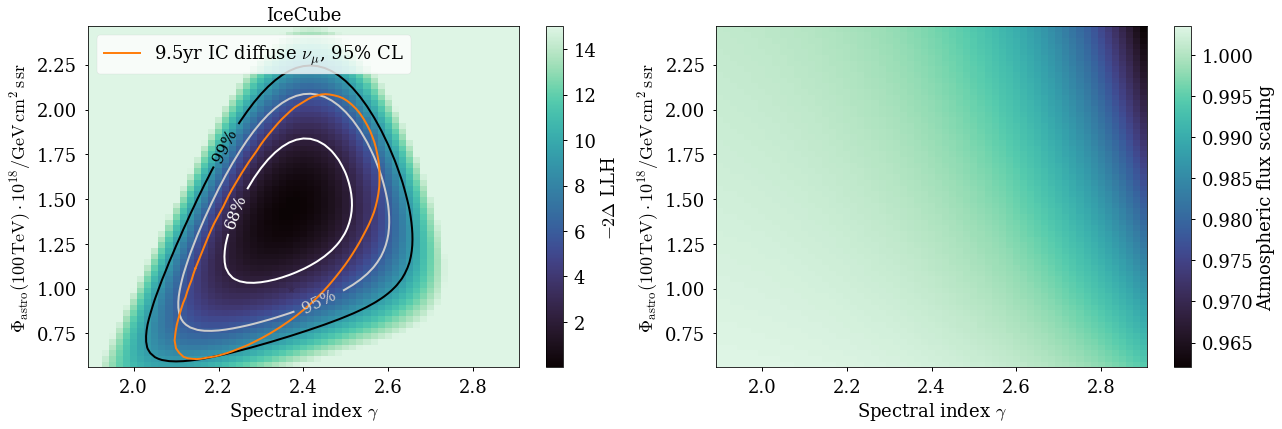

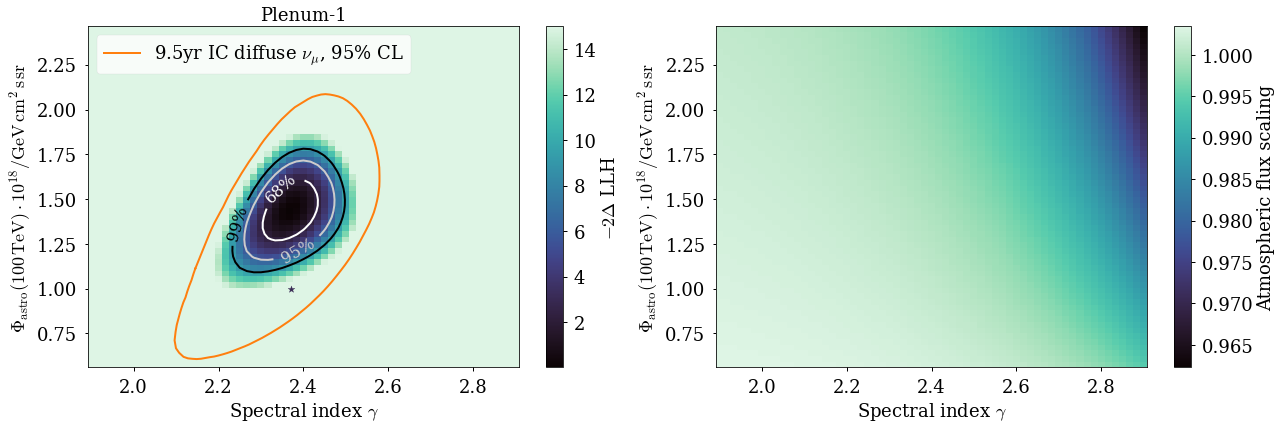

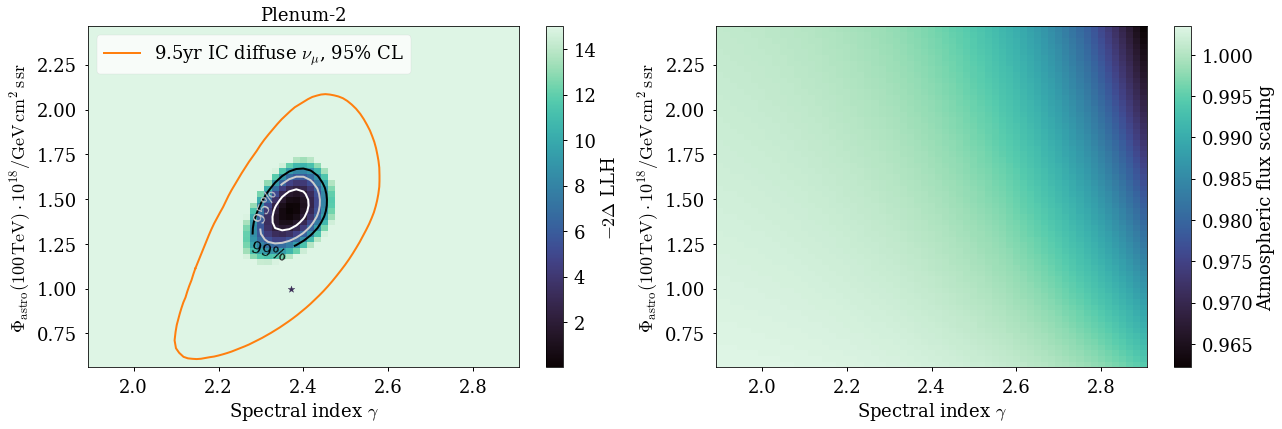

In [ ]:
ref_color = "tab:orange"
for ident in idents:
    print(ident)
    ### plotting ###
    f, axes = plt.subplots(ncols=2, figsize=(18, 6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling * PHI_ASTRO_FACTOR,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        vmax=15,  # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    cb = plt.colorbar(im, ax=ax)
    # draw contour levels
    cvals = np.array([0.32, 0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    lbs = np.array(["68%", "95%", "99%"])
    sc = ax.contour(
        gamma_astro_scaling,
        astro_scaling * PHI_ASTRO_FACTOR,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "k"],
    )
    ax.scatter(bf_SPL["gamma"][ident], bf_SPL["phi_astro"][ident], marker="*", s=50)
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.plot(
        diffuse_10yr_ref[0],
        diffuse_10yr_ref[1],
        color=ref_color,
        label=r"9.5yr IC diffuse $\nu_\mu$, 95% CL",
    )
    ax.legend(loc=2)
    ax.set_ylabel(
        r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$"
    )
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)

    # in addition, check the nuisance parameter of conventional flux
    ax = axes[1]
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling * PHI_ASTRO_FACTOR,
        local_SPL["conv"][ident],
    )
    ax.set_ylabel(
        r"$\Phi_{\rm astro} (100\,{\rm TeV})\cdot 10^{18} / {\rm GeV\, cm^2\, s\, sr}$"
    )
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")

    f.tight_layout()
    f.savefig(f"../plots/2D_scan_diffuse_spl_{ident}.pdf")


## 1D scan with cutoff

IceCube
starting local fits...
alternative: powerlaw fit (conv, phi_astro, gamma) [0.99833903 0.75475208 2.41445494]
params at min verified with scan: (conv, phi_astro, gamma) 0.9982998527114371 1.841379310344828 2.033333333333333
min TS: -26055.89303889763 verified with scan: -26055.862934171517
Raw TS vals of powerlaw vs cutoff: -26055.89303889763 -26058.13118124153
P-VALUE: 0.13464265159856253 , SIGNIFICANCE: 1.4960422266433895
Plenum-1
starting local fits...
alternative: powerlaw fit (conv, phi_astro, gamma) [0.99834709 0.76031031 2.41226617]
params at min verified with scan: (conv, phi_astro, gamma) 0.9983131285277642 1.841379310344828 2.033333333333333
min TS: -32723.138387919615 verified with scan: -32723.039745651287
Raw TS vals of powerlaw vs cutoff: -32723.138387919615 -32734.17892016562
P-VALUE: 0.0008914126594663624 , SIGNIFICANCE: 3.322729637813843
Plenum-2
starting local fits...
alternative: powerlaw fit (conv, phi_astro, gamma) [0.99834752 0.75720041 2.41316688]
params a

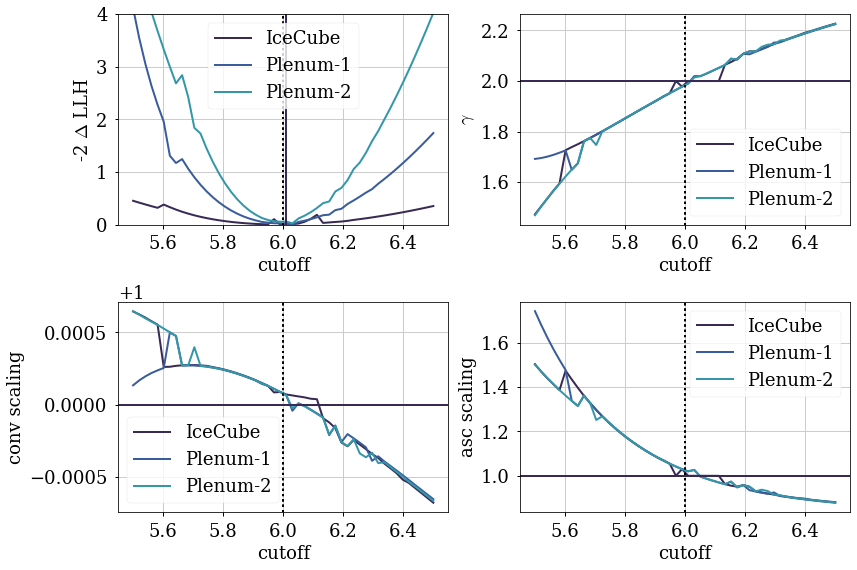

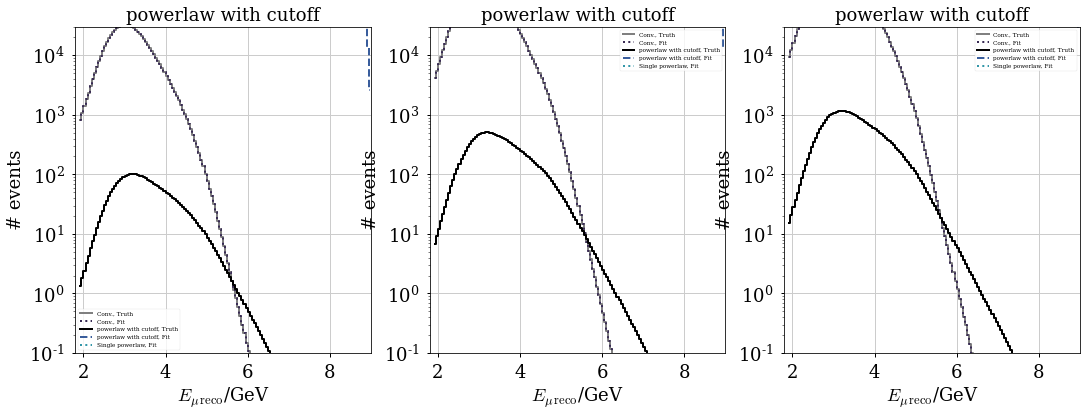

In [ ]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
verbose = False
num = 50
cutoff = np.linspace(5.5, 6.5, num=num)

num1 = 30
gamma_astro_scaling = np.linspace(1.9, 2.7, num=num1 + 1)
astro_scaling = np.linspace(0.4, 2.6, num=num1)

ts_mins_pl = {}
gamma_mins_pl = {}
phi_astro_mins_pl = {}

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
f1, axes1 = plt.subplots(ncols=3, figsize=(18, 6))
for li, ident in enumerate(idents):
    print(ident)
    shape = "powerlaw with cutoff"
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    if "Plenum" in ident:
        aeff_factor += (
            aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
            * LIVETIME
        )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor=aeff_factor, flux=base_flux_collection[shape])
    fit_config = dict(
        mu_base=aeff_factor,
        k_i=k_i,
        e_0=E_NORM,
        phi_0=PHI_ASTRO,
        normed_kvals=energy_resolution,
        shape=shape,
    )
    # global min
    global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
    out = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, *base_flux_collection[shape][1:-2]),
        bounds=[(1e-3, 1e2), *bounds_flux_collection[shape][:-2]],
        approx_grad=True,
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
        print("bf param:", out[0])
        print("TS:", out[1])
        print("* *" * 20)

    local_ts_min = np.zeros(num)
    local_param_min = {
        "gamma": np.zeros(num),
        "conv": np.zeros(num),
        "asc": np.zeros(num),
    }
    for i, cc in enumerate(cutoff):
        # local min with fixed cutoff
        local_llh = lambda x: diffuse_llh_2d_composite((*x, cc), **fit_config)
        local_out = fmin_l_bfgs_b(
            local_llh,
            x0=(1, 1, *base_flux_collection[shape][1:2]),
            approx_grad=True,
            maxls=35,
        )
        (
            local_param_min["conv"][i],
            local_param_min["asc"][i],
            local_param_min["gamma"][i],
        ) = local_out[0]
        local_ts_min[i] = local_out[1]

    # best fit powerlaw as null hypothesis
    fit_config["shape"] = "powerlaw"
    pl_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
    out_pl = fmin_l_bfgs_b(
        pl_llh,
        x0=(1, 1, GAMMA_ASTRO),
        bounds=[(1e-3, 1e2), *fx.bounds_pl_flux[:-2]],
        approx_grad=True,
    )
    gamma_mins_pl[ident] = out_pl[0][2]
    phi_astro_mins_pl[ident] = out_pl[0][1]
    ts_mins_pl[ident] = out_pl[1]

    ### verify with 2D scan that the result is the correct minimum
    local_ts_min_pl = np.zeros((num1, num1 + 1))
    local_conv_min_pl = np.zeros((num1, num1 + 1))
    print("starting local fits...")
    # scan
    for i, asc in enumerate(astro_scaling):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed phi_astro
            local_pl_llh = lambda x: diffuse_llh_2d_composite(
                (x[0], asc, gas), **fit_config
            )
            local_out = fmin_l_bfgs_b(
                local_pl_llh,
                x0=[1.1],
                approx_grad=True,
            )
            (local_conv_min_pl[i][j],) = local_out[0]
            local_ts_min_pl[i][j] = local_out[1]
    print("alternative: powerlaw fit (conv, phi_astro, gamma)", out_pl[0])
    iag, ias = np.unravel_index(local_ts_min_pl.argmin(), local_ts_min_pl.shape)
    print(
        "params at min verified with scan: (conv, phi_astro, gamma)",
        local_conv_min_pl.flatten()[local_ts_min_pl.argmin()],
        astro_scaling[ias],
        gamma_astro_scaling[iag],
    )
    print("min TS:", out_pl[1], "verified with scan:", np.min(local_ts_min_pl))
    print("Raw TS vals of powerlaw vs cutoff:", out_pl[1], out[1])
    pval = chi2.sf(out_pl[1] - out[1], 1)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)

    # plot best-fit event distributions and truth

    ax = axes1[li]
    events = [
        np.sum(
            atmo_background(aeff_factor, spl_vals, normed_kvals=energy_resolution),
            axis=0,
        ),
        np.sum(
            atmo_background(
                aeff_factor, spl_vals * out[0][0], normed_kvals=energy_resolution
            ),
            axis=0,
        ),
        np.sum(
            astro_flux(
                aeff_factor,
                emids=emids,
                normed_kvals=energy_resolution,
                phi_scaling=1,
                flux_shape=fx.baseline_pl_flux,
            ),
            axis=0,
        ),
        np.sum(
            astro_flux(
                aeff_factor,
                emids=emids,
                normed_kvals=energy_resolution,
                phi_scaling=1,
                flux_shape=fx.PLcut_flux(*out[0][1:], E_NORM, "powerlaw with cutoff"),
            ),
            axis=0,
        ),
        np.sum(
            astro_flux(
                aeff_factor,
                emids=emids,
                normed_kvals=energy_resolution,
                phi_scaling=1,
                flux_shape=fx.PL_flux(*out_pl[0][1:], E_NORM, "powerlaw"),
            ),
            axis=0,
        ),
    ]
    plot_labels = [
        "Conv., Truth",
        "Conv., Fit",
        shape + ", Truth",
        shape + ", Fit",
        "Single powerlaw, Fit",
    ]
    ls = ["-", ":", "-", "--", ":"]
    color = ["gray", None, "k", None, None]
    f, ax = plot_spectrum(
        logE_reco_mids, events, plot_labels, title=shape, f=f, ax=ax, ls=ls, color=color
    )
    ax.legend(fontsize="xx-small", loc=1, ncol=2)
    f.tight_layout()

    ## some plots for checking that the scans were ok
    ax = axes[0][0]
    ax.plot(cutoff, local_ts_min - out[1], label=ident)
    ax.set_ylabel(r"-2 $\Delta$ LLH")
    ax.set_xlabel("cutoff")
    ax.legend(loc=0)
    ax.axvline(fx.baseline_cut_flux[2], color="k", ls=":")
    ax.axvline(out[0][-1])
    ax.set_ylim(0, 4)

    ax = axes[0][1]
    ax.set_ylabel(r"$\gamma$")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["gamma"], label=ident)
    ax.legend(loc=0)
    ax.axvline(fx.baseline_cut_flux[2], color="k", ls=":")
    ax.axhline(fx.baseline_cut_flux[1])

    ax = axes[1][0]
    ax.set_ylabel(r"conv scaling")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["conv"], label=ident)
    ax.legend(loc=0)
    ax.axvline(fx.baseline_cut_flux[2], color="k", ls=":")
    ax.axhline(1)

    ax = axes[1][1]
    ax.set_ylabel(r"asc scaling")
    ax.set_xlabel("cutoff")
    ax.plot(cutoff, local_param_min["asc"], label=ident)
    ax.legend(loc=0)
    ax.axvline(fx.baseline_cut_flux[2], color="k", ls=":")
    ax.axhline(1)
    axes1[li].legend(fontsize="xx-small", loc=0)
f.tight_layout()


## 2D scans with cutoff

In [ ]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
verbose = False
num = 50
cutoff = np.linspace(4.5, 8.5, num=num)
gamma_astro_scaling = np.linspace(1.0, 2.9, num=num)
bf_PLC = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}, "cutoff": {}}
local_mins_PLC = {"ts": {}, "conv": {}, "phi_astro": {}}
shape = "powerlaw with cutoff" # 3 fit parameters

for li, ident in enumerate(idents):
    print(ident)
    aeff_factor = (
        aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
    )
    if "Plenum" in ident:
        aeff_factor += (
            aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
            * LIVETIME
        )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor=aeff_factor, flux=base_flux_collection[shape])
    fit_config = dict(
        mu_base=aeff_factor,
        k_i=k_i,
        e_0=E_NORM,
        phi_0=PHI_ASTRO,
        normed_kvals=energy_resolution,
        shape=shape,
    )
    # global min
    global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
    out = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, *base_flux_collection[shape][1:-2]),
        bounds=[(1e-3, 1e2), *bounds_flux_collection[shape][:-2]],
        approx_grad=True,
    )
    bf_PLC["ts"][ident] = out[1]
    (
        bf_PLC["conv"][ident],
        bf_PLC["phi_astro"][ident],
        bf_PLC["gamma"][ident],
        bf_PLC["cutoff"][ident],
    ) = out[0]
    if out[2]["warnflag"] != 0:
        print("WARNING!! Something weird happened with the fit")

    local_mins_PLC["ts"][ident] = np.zeros((len(cutoff), len(gamma_astro_scaling)))
    local_mins_PLC["conv"][ident] = np.zeros((len(cutoff), len(gamma_astro_scaling)))
    local_mins_PLC["phi_astro"][ident] = np.zeros(
        (len(cutoff), len(gamma_astro_scaling))
    )
    print("starting local fits...")
    # scan
    nwarn = 0
    for i, csc in enumerate(cutoff):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed cutoff and gamma
            local_llh = lambda x: diffuse_llh_2d_composite((*x, gas, csc), **fit_config)
            local_out = fmin_l_bfgs_b(
                local_llh,
                x0=(1, 1),
                approx_grad=True,
                maxls=35,
            )
            if local_out[2]["warnflag"] == 0:
                (
                    local_mins_PLC["conv"][ident][i][j],
                    local_mins_PLC["phi_astro"][ident][i][j],
                ) = local_out[0]
                local_mins_PLC["ts"][ident][i][j] = local_out[1]
            else:
                strng = "WARNING!! Something weird happened with the fit"
                strng += "\nParameters: cutoff={}, gamma={}".format(csc, gas)
                strng += "\n Fit Output:" + str(local_out)
                # print(strng)
                local_mins_PLC["conv"][ident][i][j] = np.nan
                local_mins_PLC["phi_astro"][ident][i][j] = np.nan
                local_mins_PLC["ts"][ident][i][j] = np.nan
                nwarn += 1
    print("Number of warnings:", nwarn)
    print("Done")


IceCube
starting local fits...
Number of warnings: 0
Done
Plenum-1
starting local fits...
Number of warnings: 0
Done
Plenum-2
starting local fits...
Number of warnings: 0
Done


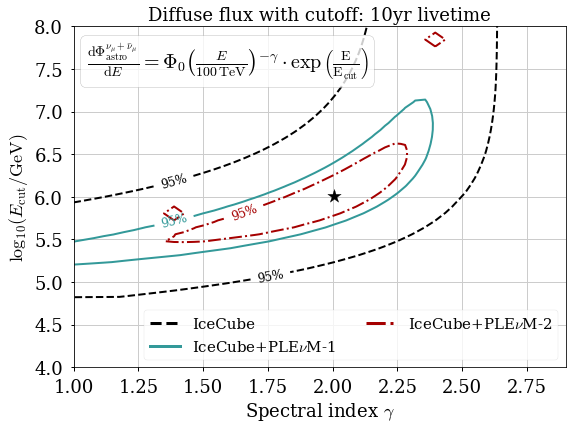

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
cvals = [0.05]
lbs = ["95%"]
levels = chi2.isf(cvals, 2)
for ident in idents:
    # draw contour levels
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        lw=3, **contour_formats[ident]
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=12)
    
ax.scatter(bf_PLC["gamma"][ident], bf_PLC["cutoff"][ident], marker="*", s=200, color="k")
handles, _ = ax.get_legend_handles_labels()
handles.extend([
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color=contour_formats["IceCube"]["colors"][0], ls=contour_formats["IceCube"]["linestyles"], lw=3, label="IceCube"),
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color=contour_formats["Plenum-1"]["colors"][0], ls=contour_formats["Plenum-1"]["linestyles"], lw=3, label=r"IceCube+PLE$\nu$M-1"),    
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color=contour_formats["Plenum-2"]["colors"][0], ls=contour_formats["Plenum-2"]["linestyles"], lw=3, label=r"IceCube+PLE$\nu$M-2")
])
ax.legend(handles=handles, loc=4, ncol=2, fontsize=15)
ax.set_ylim(4.0, 8)
flux_str = r"$\frac{{\rm d}\Phi_{\rm astro}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
flux_str += r"= \Phi_0 \left( \frac{E}{\rm 100\,TeV} \right)^{-\gamma}"
flux_str += r" \cdot \exp \left( \frac{E}{E_{\rm cut}}\right)$"
ax.text(
    1.05, 7.5, flux_str, fontsize=20,
    bbox=dict(boxstyle='round', facecolor="w", edgecolor="gray", alpha=0.8)
)
ax.set_ylabel(r"$\log_{10}(E_{\rm cut} / {\rm GeV})$")
ax.set_xlabel(r"Spectral index $\gamma$")
ax.set_title("Diffuse flux with cutoff: 10yr livetime")
f.tight_layout()
f.savefig(f"../plots/2D_scan_diffuse_pl-cut_comparison_gamma-cut.pdf")

IceCube
Plenum-1
Plenum-2


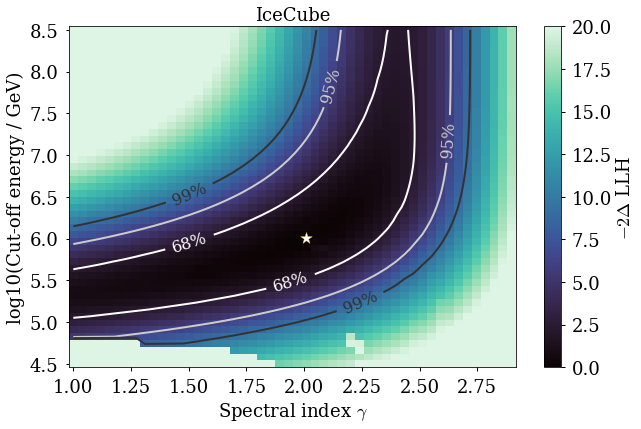

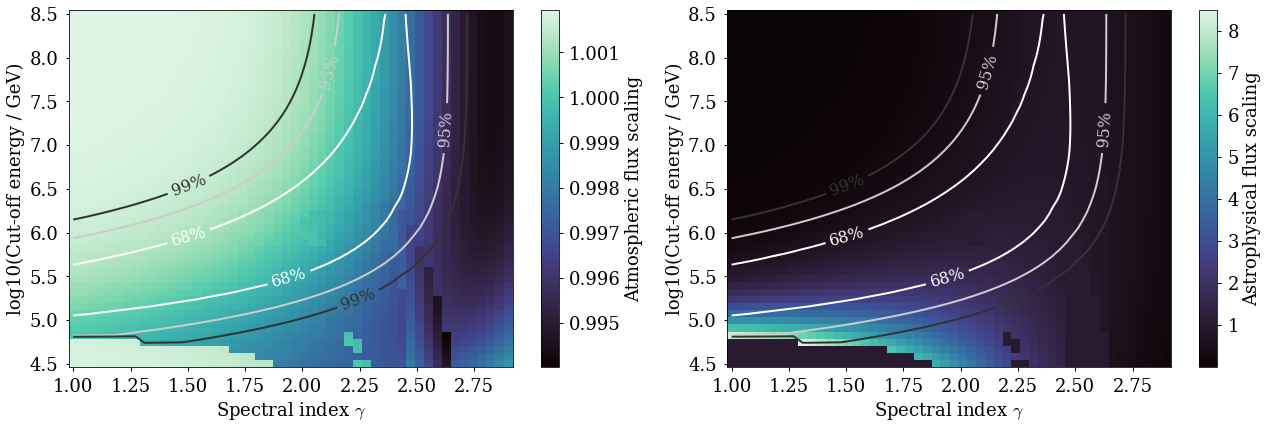

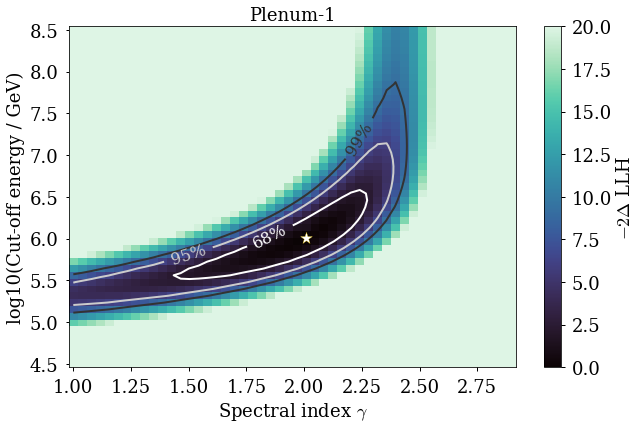

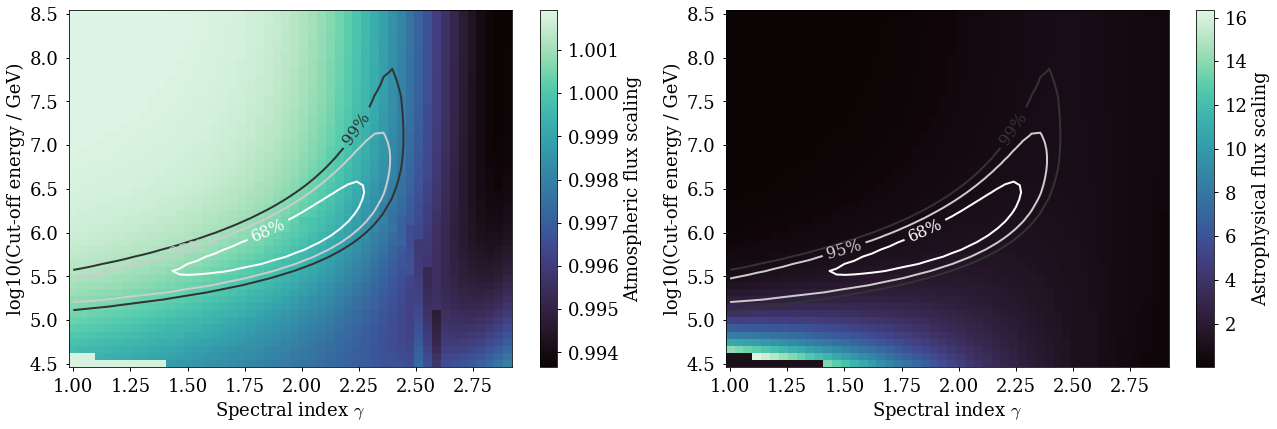

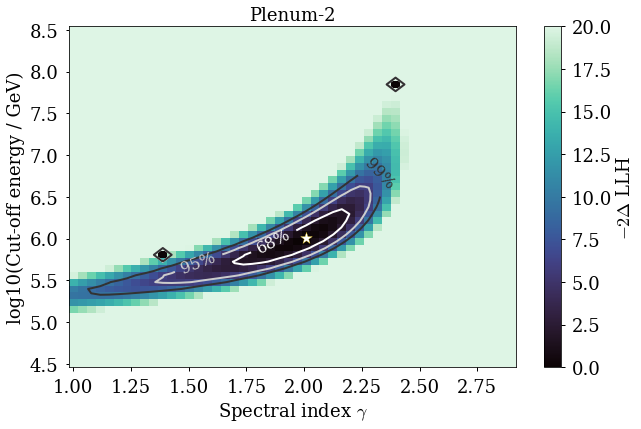

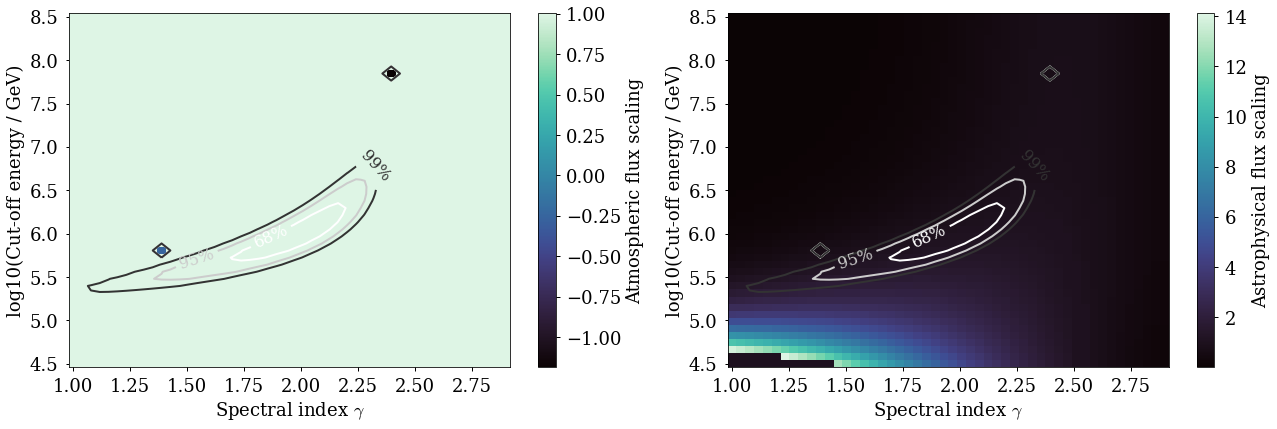

In [ ]:
### white pixels are failed fits
for ident in idents:
    print(ident)
    ### plotting ###
    f, ax = plt.subplots(figsize=(9,6))
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        vmin=0,
        vmax=20
    )
    cb = plt.colorbar(im, ax=ax)
    
    # draw contour levels
    cvals = np.array([0.32, 0.05, 0.01])
    levels = chi2.isf(cvals, 2)
    lbs = np.array(["68%", "95%", "99%"])
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "0.2"]
    )
    ax.scatter(bf_PLC["gamma"][ident], bf_PLC["cutoff"][ident], marker="*", s=150, color="white", edgecolor="gold")
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    
    ax.set_ylabel(r"log10(Cut-off energy / GeV)")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)
    f.tight_layout()
    f.savefig(f"../plots/2D_scan_diffuse_pl-cut_{ident}.pdf")

    f2, ax2 = plt.subplots(ncols=2, figsize=(18,6))
    ## in addition, check the nuisance parameter of conventional flux
    ax = ax2[0]
    im = ax.pcolormesh(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["conv"][ident],
        #vmin=0.99,
    )
    
    ## add contours as reference
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "0.2"]
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.set_ylabel(r"log10(Cut-off energy / GeV)")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")
    f.tight_layout()
    
    ax = ax2[1]
    im2 = ax.pcolormesh(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["phi_astro"][ident],
        #vmin=0.99,
    )
    ## add contours as reference
    sc = ax.contour(
        gamma_astro_scaling,
        cutoff,
        local_mins_PLC["ts"][ident] - bf_PLC["ts"][ident],
        levels=levels,
        colors=["w", "0.8", "0.2"]
    )
    fmt = {l: s for l,s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.set_ylabel(r"log10(Cut-off energy / GeV)")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im2, ax=ax)
    cb.set_label(r"Astrophysical flux scaling")
    f2.tight_layout()
    

# Cutoff significance versus time/detectors

Some options:
* 10yr IceCube
* 20yr IceCube
* 40yr IceCube
* 10yr IceCube + K3N
* 10yr IceCube + K3N + GVD
* 10yr IceCube + K3N + GVD + PONE
* 10yr IceCube +  2yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube +  5yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube + 10yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube +  2yr Plenum-2 (= GEN2 + PONE + GVD + K3N)
* 10yr IceCube +  5yr Plenum-2 (= GEN2 + PONE + GVD + K3N)
* 10yr IceCube + 10yr Plenum-2 (= GEN2 + PONE + GVD + K3N)

In [ ]:
import pandas as pd

In [ ]:
# livetime relative to 10yrs
detector_configurations = [
    {"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 0, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "10y IC"},
    {"IceCube": 2.0, "Gen-2": 0, "Plenum-1": 0, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "20y IC"},
    {"IceCube": 4.0, "Gen-2": 0, "Plenum-1": 0, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "40y IC"},
    {"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 0.2, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "10y IC + 2y PL-1"},
    {"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 0.5, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "10y IC + 5y PL-1"},
    {"IceCube": 1.0, "Gen-2": 0, "Plenum-1": 1, "KM3NeT":  0, "P-ONE": 0, "Baikal-GVD": 0, "identifier": "10y IC + 10y PL-1"},
    {"IceCube": 1.0, "Gen-2": 0.2, "Plenum-1": 0, "KM3NeT": 0.2, "P-ONE": 0.2, "Baikal-GVD": 0.2, "identifier": "10y IC + 2y PL-2"},
    {"IceCube": 1.0, "Gen-2": 0.5, "Plenum-1": 0, "KM3NeT": 0.5, "P-ONE": 0.5, "Baikal-GVD": 0.5, "identifier": "10y IC + 5y PL-2"},
    {"IceCube": 1.0, "Gen-2": 1, "Plenum-1": 0, "KM3NeT": 1, "P-ONE": 1, "Baikal-GVD": 1, "identifier": "10y IC + 10y PL-2"},
]
detector_configurations = pd.DataFrame(detector_configurations)

In [ ]:
pvals = []
shape = "powerlaw with cutoff"

for idx, series in detector_configurations.iterrows():
    print(idx)
    aeff_factor = np.zeros_like(aeff_2d["IceCube"].T)
    naming = ""
    for ident, lt_factor in series.items():
        if ident == "identifier":
            continue
        if lt_factor == 0:
            continue
        print(ident)
        aeff_factor += (
            aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width)
            * LIVETIME
            * lt_factor
        )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor=aeff_factor, flux=base_flux_collection[shape])
    fit_config = dict(
        mu_base=aeff_factor,
        k_i=k_i,
        e_0=E_NORM,
        phi_0=PHI_ASTRO,
        normed_kvals=energy_resolution,
    )
    # baseline atmo
    local_llh = lambda x: diffuse_llh_2d_composite(x, shape="powerlaw", **fit_config)
    global_llh = lambda x: diffuse_llh_2d_composite(x, shape=shape, **fit_config)
    # global min
    out = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, *base_flux_collection[shape][1:-2]),
        approx_grad=True,
        factr=10,
    )
    # check that the TS at the fit minimum is close to the TS of the baseline params
    baseline_ts_check = np.isclose(
        out[1],
        global_llh(
            (1, 1, *base_flux_collection[shape][1:-2]),
        ),
        rtol=1e-2,
    )
    print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
    # best fit powerlaw as null hypothesis
    out_pl = fmin_l_bfgs_b(
        local_llh,
        x0=(1.1, 1, GAMMA_ASTRO),
        approx_grad=True,
    )
    pval = chi2.sf(out_pl[1] - out[1], 1)
    sigma = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, ", SIGNIFICANCE:", sigma)
    pvals.append(
        {
            "identifier": series.identifier,  # str(idx) + ", " +
            "idx": idx,
            "pval": pval,
            r"Significance in $\sigma$": sigma,
        }
    )

pval_df = pd.DataFrame(pvals)
pval_df[r"$-\log_{10}$(p-value)"] = -np.log10(pval_df.pval)


0
IceCube
TS asimov check: OK
P-VALUE: 0.13464341410806946 , SIGNIFICANCE: 1.4960393003983838
1
IceCube
TS asimov check: OK
P-VALUE: 0.034360143426900705 , SIGNIFICANCE: 2.1158197180184466
2
IceCube
TS asimov check: OK
P-VALUE: 0.0027696188866577964 , SIGNIFICANCE: 2.9922141678222354
3
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.046436704337120716 , SIGNIFICANCE: 1.9914020474762895
4
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.010148035493456664 , SIGNIFICANCE: 2.570743851184726
5
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.0008909474801274543 , SIGNIFICANCE: 3.322875252954286
6
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 0.008944039364410728 , SIGNIFICANCE: 2.6141857594414
7
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 0.0002095440995895019 , SIGNIFICANCE: 3.7072233819133644
8
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 5.006172631094251e-07 , SIGNIFICANCE: 5.026076112816075


In [ ]:
from settings import many_colors

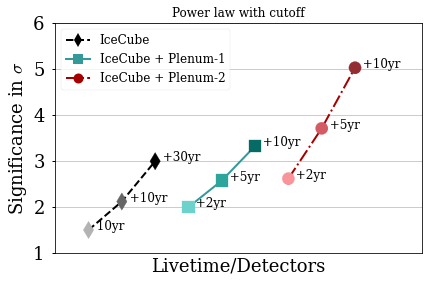

In [ ]:
### plot significance vs livetime/detector configs
f, ax = plt.subplots(figsize=(6, 4))
label_size = 12
# ICECUBE
ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"], 
    pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"], color=poles["IceCube"]["color"],
    marker="d", label="IceCube", ms=10
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"], 
    y=pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"], 
    c=many_colors[:3], s=150, zorder=10, marker="d"
)
ax.text(
    x=pval_df.loc[0]["identifier"], 
    y=pval_df.loc[0][r"Significance in $\sigma$"],
    s="  10yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[1]["identifier"], 
    y=pval_df.loc[1][r"Significance in $\sigma$"],
    s="  +10yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[2]["identifier"], 
    y=pval_df.loc[2][r"Significance in $\sigma$"],
    s="  +30yr", fontsize=label_size
)

## PLENUM-1
ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"], 
    pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"], color=poles["Plenum-1"]["color"],
    marker="s", label="IceCube + Plenum-1", ms=10
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"], 
    y=pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"], 
    c=many_colors[6:], s=150, zorder=10, marker="s"
)
ax.text(
    x=pval_df.loc[3]["identifier"], 
    y=pval_df.loc[3][r"Significance in $\sigma$"],
    s="  +2yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[4]["identifier"], 
    y=pval_df.loc[4][r"Significance in $\sigma$"],
    s="  +5yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[5]["identifier"], 
    y=pval_df.loc[5][r"Significance in $\sigma$"],
    s="  +10yr", fontsize=label_size
)


## PLENUM-2
ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"], 
    pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    ls=poles["Plenum-2"]["ls"], color=poles["Plenum-2"]["color"],
    marker="o", label="IceCube + Plenum-2", ms=10
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"], 
    y=pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"], 
    c=many_colors[3:6], s=150, zorder=10, marker="o"
)
ax.text(
    x=pval_df.loc[6]["identifier"], 
    y=pval_df.loc[6][r"Significance in $\sigma$"],
    s="  +2yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[7]["identifier"], 
    y=pval_df.loc[7][r"Significance in $\sigma$"],
    s="  +5yr", fontsize=label_size
)
ax.text(
    x=pval_df.loc[8]["identifier"], 
    y=pval_df.loc[8][r"Significance in $\sigma$"],
    s="  +10yr", fontsize=label_size
)

ax.set_xlim(-1, 10)
ax.set_ylim(1, 6)
ax.set_xticks([])
ax.legend(fontsize=label_size)
ax.set_title("Power law with cutoff", fontsize=label_size)
ax.set_xlabel("Livetime/Detectors")
ax.set_ylabel(r"Significance in $\sigma$")
plt.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_det_talk.pdf")

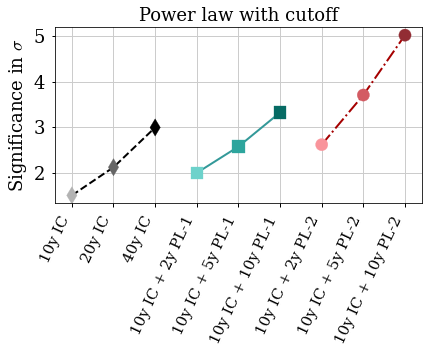

In [ ]:
# same plot, alternative labeling as in PoS(ICRC2021)1185 
f, ax = plt.subplots(figsize=(6, 5))

ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"], 
    pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"], color=poles["IceCube"]["color"]
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"], 
    y=pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"], 
    c=many_colors[:3], s=150, zorder=10, marker="d"
)

ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"], 
    pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"], color=poles["Plenum-1"]["color"]
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"], 
    y=pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"], 
    c=many_colors[6:], s=150, zorder=10, marker="s"
)

ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"], 
    pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    ls=poles["Plenum-2"]["ls"], color=poles["Plenum-2"]["color"]
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"], 
    y=pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"], 
    c=many_colors[3:6], s=150, zorder=10, marker="o"
)


#ax.set_ylim(0, 5.5)
ax.set_title("Power law with cutoff")
ax.set_xlabel("")
ax.set_ylabel(r"Significance in $\sigma$")
plt.xticks(rotation=65, fontsize=15, ha="right")
plt.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_det.pdf")

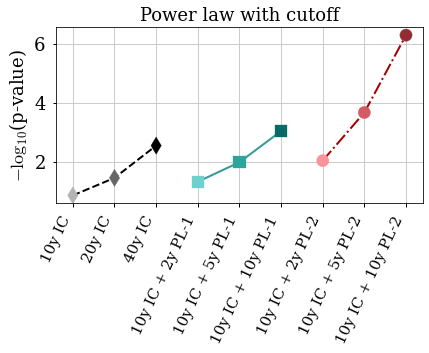

In [ ]:
f, ax = plt.subplots(figsize=(6, 5))
ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"], 
    pval_df.loc[[0, 1, 2]][r"$-\log_{10}$(p-value)"],
    ls=contour_formats["IceCube"]["linestyles"], color=poles["IceCube"]["color"]
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"], 
    y=pval_df.loc[[0, 1, 2]][r"$-\log_{10}$(p-value)"], 
    c=many_colors[:3], s=150, zorder=10, marker="d"
)

ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"], 
    pval_df.loc[[3, 4, 5]][r"$-\log_{10}$(p-value)"],
    ls=poles["Plenum-1"]["ls"], color=poles["Plenum-1"]["color"]
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"], 
    y=pval_df.loc[[3, 4, 5]][r"$-\log_{10}$(p-value)"], 
    c=many_colors[6:], s=150, zorder=10, marker="s"
)

ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"], 
    pval_df.loc[[6, 7, 8]][r"$-\log_{10}$(p-value)"],
    ls=poles["Plenum-2"]["ls"], color=poles["Plenum-2"]["color"]
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"], 
    y=pval_df.loc[[6, 7, 8]][r"$-\log_{10}$(p-value)"], 
    c=many_colors[3:6], s=150, zorder=10, marker="o"
)

ax.set_title("Power law with cutoff")
ax.set_xlabel("")
ax.set_ylabel(r"$-\log_{10}$(p-value)")
plt.xticks(rotation=65, fontsize=15, ha="right")
plt.tight_layout()
plt.savefig("../plots/cutoff_pval_vs_det.pdf")

## Significance vs cutoff value

In [ ]:
print_names = {
    "IceCube": "IceCube",
    "Plenum-1": r"IceCube + PLE$\nu$M-1",
    "Plenum-2": r"IceCube + PLE$\nu$M-2"
}

In [ ]:
pvals = []
cutoff_vals = np.round(np.arange(5.0, 8.1, step=0.2), 1)
for e_cut in cutoff_vals:
    for li, ident in enumerate(idents):
        shape = "powerlaw with cutoff"
        aeff_factor = (
            aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
        )
        if "Plenum" in ident:
            aeff_factor += (
                aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
                * LIVETIME
            )
        # asimov = expectation of perfect experiment
        current_flux = fx.PLcut_flux(
            base_flux_collection[shape].norm,
            base_flux_collection[shape].gamma,
            e_cut,
            E_NORM,
            shape,
        )
        k_i = asimov_data(aeff_factor=aeff_factor, flux=current_flux)
        fit_config = dict(
            mu_base=aeff_factor,
            k_i=k_i,
            e_0=E_NORM,
            phi_0=PHI_ASTRO,
            normed_kvals=energy_resolution,
        )
        # baseline atmo+astro-pl
        local_llh = lambda x: diffuse_llh_2d_composite(
            x, shape="powerlaw", **fit_config
        )
        global_llh = lambda x: diffuse_llh_2d_composite(x, shape=shape, **fit_config)
        # global min
        out = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, *current_flux[1:-2]),
            bounds=((1E-1, 1E2), (1E-1, 1E2), (1, 10), (1, 10)),
            approx_grad=True,
            factr=10,
        )
        # check that the TS at the fit minimum is close to the TS of the baseline params
        baseline_ts_check = np.isclose(
            out[1],
            global_llh(
                (1, 1, *current_flux[1:-2]),
            ),
            rtol=1e-2,
        )
        if not baseline_ts_check:
            print("TS asimov check: not OK :(")
            print(out[0], out[1])
            print((1, 1, *current_flux[1:-2]))
        # best fit powerlaw as null hypothesis
        out_pl = fmin_l_bfgs_b(
            local_llh,
            x0=(1.1, 1.1, GAMMA_ASTRO),
            bounds=((1E-1, 1E2), (1E-1, 1E2), (1, 10)),
            approx_grad=True,
        )
        pval = chi2.sf(out_pl[1] - out[1], 1)
        significance = erfinv(1 - pval) * np.sqrt(2)
        pvals.append(
            {
                "ident": print_names[ident],
                "pval": pval,
                r"Significance in $\sigma$": significance,
                r"$\log_{10}(E_{\rm cut}/{\rm GeV})$": e_cut,
                r"Conv_PL": out_pl[0][0],
                r"$\gamma_{PL}$": out_pl[0][1],
                r"$\Phi_{0,PL}$": out_pl[0][2],
                r"Conv": out[0][0],
                r"$\gamma$": out[0][1],
                r"$\Phi_{0}$": out[0][2],
                r"$E_{\rm cut}$": out[0][3],
            }
        )

pval_df = pd.DataFrame(pvals)
pval_df[r"$-\log_{10}$(p-value)"] = -np.log10(pval_df.pval)


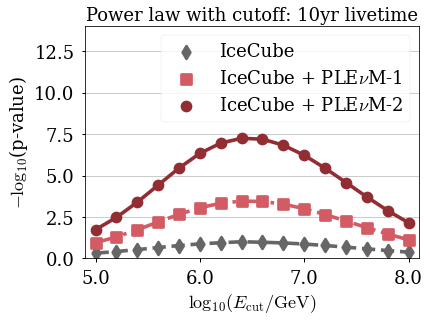

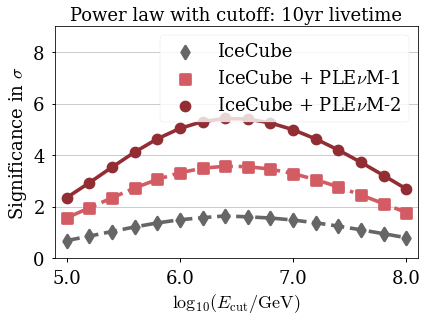

In [ ]:
f, ax = plt.subplots(figsize=(6, 4.5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$-\log_{10}$(p-value)", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    palette=many_colors[[1, 4, 5]], linestyles=["--", "-.", "-"], markers=["d", "s", "o"]
)
ax.set_title("Power law with cutoff: 10yr livetime")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1) #, fontsize="x-small")
ax.set_ylim(0, 14)
plt.tight_layout()
plt.savefig("../plots/cutoff_pval_vs_cutoff.pdf")

f, ax = plt.subplots(figsize=(6, 4.5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"Significance in $\sigma$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    palette=many_colors[[1, 4, 5]], linestyles=["--", "-.", "-"], markers=["d", "s", "o"]
)
ax.set_title("Power law with cutoff: 10yr livetime")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1) #, fontsize="x-small")
ax.set_ylim(0, 9)
f.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_cutoff.pdf")

## check that parameter fits are ok

In [ ]:
plot_kw = dict(
    palette=many_colors[[1, 4, 5]],
    linestyles=["-", "-.", "-"],
    markers=["d", "s", "o"],
)

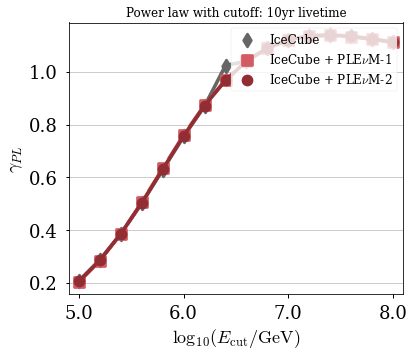

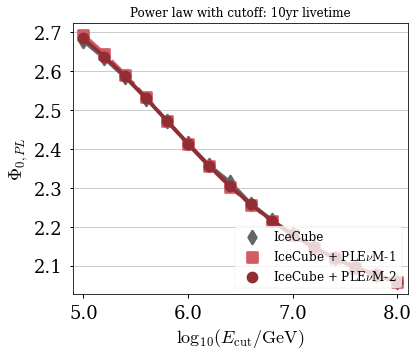

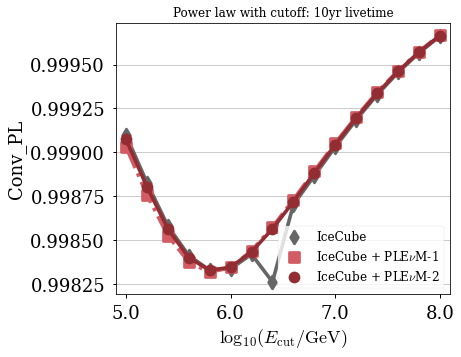

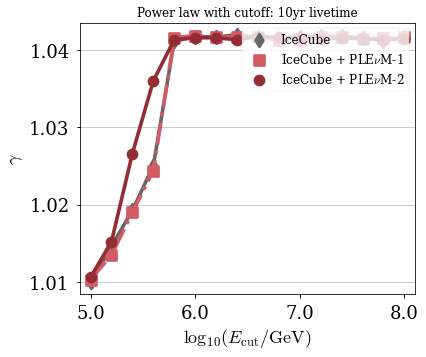

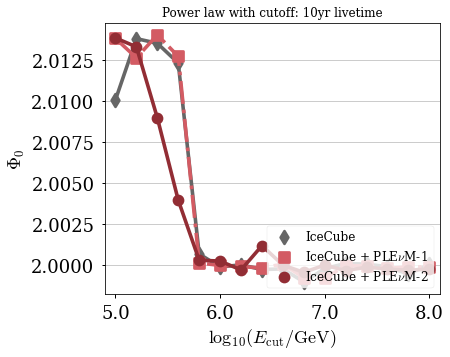

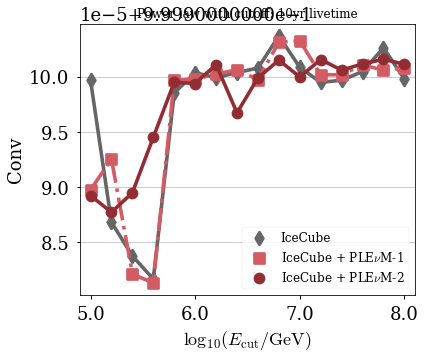

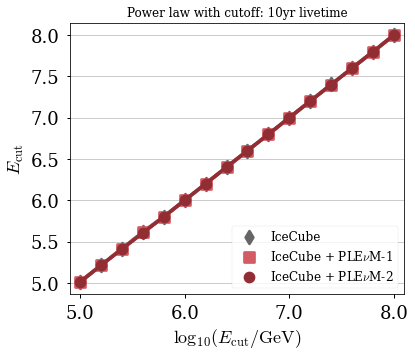

In [ ]:
fontsize = "large"
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$\gamma_{PL}$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    **plot_kw
    
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize=fontsize)
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1, fontsize=fontsize)

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$\Phi_{0,PL}$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize=fontsize)
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize=fontsize)

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"Conv_PL", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize=fontsize)
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize=fontsize)

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$\gamma$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize=fontsize)
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1, fontsize=fontsize)

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$\Phi_{0}$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize=fontsize)
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize=fontsize)

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"Conv", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize=fontsize)
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize=fontsize)

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df, hue="ident", ax=ax,
    y=r"$E_{\rm cut}$", x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$", 
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize=fontsize)
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize=fontsize)